In [8]:
import json
import re
from pathlib import Path
import pandas as pd

# Locate base directory for outputs
candidates = [
    Path("image_difficulty_classifier"),
    Path.cwd() / "image_difficulty_classifier",
    Path.cwd().parent / "image_difficulty_classifier",
]
base_dir = next((c for c in candidates if c.exists() and c.is_dir()), None)
if base_dir is None:
    raise FileNotFoundError("Could not find 'image_difficulty_classifier' directory.")

# Collect output_grid* run directories
run_dirs = [p for p in base_dir.iterdir() if p.is_dir() and p.name.startswith("output_grid")]

# Parse hyperparameters from folder name
pattern = re.compile(
    r"^output_grid_\d+_\d+_"  # timestamp
    r"(?P<model_id>[^_]+(?:_[^_]+)*)_"  # model/backbone/pretrained
    r"bs(?P<bs>\d+)_ep(?P<ep>\d+)_lr(?P<lr>[0-9.eE+-]+)_wd(?P<wd>[0-9.eE+-]+)_nb(?P<nb>\d+)_min(?P<min>\d+)_is(?P<is>\d+)_nw(?P<nw>\d+)_seed(?P<seed>\d+)(?:_(?P<uniq>\d+))?$"
)

def parse_from_name(name: str) -> dict:
    m = pattern.match(name)
    if not m:
        return {"run_name": name}
    d = m.groupdict()
    for k in ["bs", "ep", "nb", "min", "is", "nw", "seed", "uniq"]:
        if k in d and d[k] is not None:
            d[k] = int(d[k])
    for k in ["lr", "wd"]:
        if k in d and d[k] is not None:
            d[k] = float(d[k])
    d["run_name"] = name
    return d

records = []
for rd in run_dirs:
    metrics_path = rd / "test_metrics.json"
    if not metrics_path.exists():
        continue
    try:
        with open(metrics_path, "r", encoding="utf-8") as f:
            metrics = json.load(f)
        info = parse_from_name(rd.name)
        info.update({
            "accuracy": float(metrics.get("accuracy", float("nan"))),
            "loss": float(metrics.get("loss", float("nan"))),
            "num_samples": float(metrics.get("num_samples", float("nan"))),
            "num_steps": float(metrics.get("num_steps", float("nan"))),
            "time_sec": float(metrics.get("time_sec", float("nan"))),
            "path": str(rd),
        })
        records.append(info)
    except Exception as e:
        print(f"Failed to read {metrics_path}: {e}")

# DataFrame of all runs
df = pd.DataFrame.from_records(records)
# Normalize model_id to shorter labels
if not df.empty and "model_id" in df.columns:
    df["model_id_short"] = df["model_id"].str.replace("CLIP_MLP_", "", regex=False).str.replace("CLIP_LINEAR_", "", regex=False)
else:
    df["model_id_short"] = df.get("run_name", pd.Series(dtype=str))

df.sort_values(["nb", "model_id_short", "wd", "lr", "bs"], inplace=True, ignore_index=True)
df


,model_id,bs,ep,lr,wd,nb,min,is,nw,seed,uniq,run_name,accuracy,loss,num_samples,num_steps,time_sec,path,model_id_short
0,CLIP_LINEAR_ViT_B_16_openai,64,20,0.0002,0.01,2,0,224,4,42,NaN,output_grid_20250818_071605_CLIP_LINEAR_ViT_B_...,0.6700,0.601703,5000.0,79.0,8.717903,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_16_openai
1,CLIP_LINEAR_ViT_B_16_openai,64,20,0.0002,0.01,2,0,224,4,42,1.0,output_grid_20250818_071605_CLIP_LINEAR_ViT_B_...,0.6700,0.601703,5000.0,79.0,11.575494,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_16_openai
2,CLIP_LINEAR_ViT_B_16_openai,64,20,0.0002,0.01,2,0,224,4,42,2.0,output_grid_20250818_071605_CLIP_LINEAR_ViT_B_...,0.5202,0.729754,5000.0,79.0,10.627095,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_16_openai
3,CLIP_LINEAR_ViT_B_16_openai,64,20,0.0002,0.01,2,0,224,4,42,3.0,output_grid_20250818_071605_CLIP_LINEAR_ViT_B_...,0.5202,0.729754,5000.0,79.0,9.463389,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_16_openai
4,CLIP_MLP_ViT_B_16_openai,64,20,0.0002,0.01,2,0,224,4,42,NaN,output_grid_20250818_071605_CLIP_MLP_ViT_B_16_...,0.7042,1.308582,5000.0,79.0,9.711438,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_16_openai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,CLIP_LINEAR_ViT_B_32_openai,128,20,0.0005,0.05,5,0,224,4,42,3.0,output_grid_20250818_071605_CLIP_LINEAR_ViT_B_...,0.2238,1.606209,5000.0,40.0,8.135121,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_32_openai
251,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.05,5,0,224,4,42,NaN,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.2982,3.204123,5000.0,40.0,15.622764,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_32_openai
252,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.05,5,0,224,4,42,1.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.2982,3.204123,5000.0,40.0,11.633820,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_32_openai
253,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.05,5,0,224,4,42,2.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.1958,1.609476,5000.0,40.0,9.880066,q:\Projects\BMM_school\Universal_learning\Prog...,ViT_B_32_openai


In [9]:
import os
import json
import re
from pathlib import Path
import pandas as pd

# Resolve base directory containing model outputs
candidates = [
    Path("image_difficulty_classifier"),
    Path.cwd() / "image_difficulty_classifier",
    Path.cwd().parent / "image_difficulty_classifier",
]
base_dir = None
for c in candidates:
    if (c).exists() and (c).is_dir():
        base_dir = c
        break
if base_dir is None:
    raise FileNotFoundError("Could not find 'image_difficulty_classifier' directory from current working directory.")

# Collect output_grid* directories
run_dirs = [p for p in base_dir.iterdir() if p.is_dir() and p.name.startswith("output_grid")]
if not run_dirs:
    print("No output_grid* directories found under:", base_dir)

# Helper to parse hyperparameters from folder name suffix
# Example name: output_grid_20250818_071605_CLIP_MLP_ViT_B_32_openai_bs64_ep20_lr0.0005_wd0.05_nb5_min0_is224_nw4_seed42_3
pattern = re.compile(
    r"^output_grid_\d+_\d+_"  # timestamp
    r"(?P<model_id>[^_]+(?:_[^_]+)*)_"  # model id (greedy up to _bs)
    r"bs(?P<bs>\d+)_ep(?P<ep>\d+)_lr(?P<lr>[0-9.eE+-]+)_wd(?P<wd>[0-9.eE+-]+)_nb(?P<nb>\d+)_min(?P<min>\d+)_is(?P<is>\d+)_nw(?P<nw>\d+)_seed(?P<seed>\d+)(?:_(?P<uniq>\d+))?$"
)

def parse_from_name(name: str) -> dict:
    m = pattern.match(name)
    if not m:
        return {"run_name": name}
    d = m.groupdict()
    # Coerce types
    for k in ["bs", "ep", "nb", "min", "is", "nw", "seed"]:
        if k in d and d[k] is not None:
            d[k] = int(d[k])
    for k in ["lr", "wd"]:
        if k in d and d[k] is not None:
            d[k] = float(d[k])
    if d.get("uniq") is not None:
        d["uniq"] = int(d["uniq"])
    d["run_name"] = name
    return d

records = []
for rd in run_dirs:
    metrics_path = rd / "test_metrics.json"
    if not metrics_path.exists():
        continue
    try:
        with open(metrics_path, "r", encoding="utf-8") as f:
            metrics = json.load(f)
        info = parse_from_name(rd.name)
        info.update({
            "accuracy": float(metrics.get("accuracy", float("nan"))),
            "loss": float(metrics.get("loss", float("nan"))),
            "num_samples": float(metrics.get("num_samples", float("nan"))),
            "num_steps": float(metrics.get("num_steps", float("nan"))),
            "time_sec": float(metrics.get("time_sec", float("nan"))),
            "path": str(rd),
        })
        records.append(info)
    except Exception as e:
        print(f"Failed to read {metrics_path}: {e}")

df = pd.DataFrame.from_records(records)
# Derive compact label for plotting
if not df.empty:
    if "model_id" in df.columns:
        df["label"] = df.apply(lambda r: f"{r['model_id']}|bs{r['bs']}|lr{r['lr']}|wd{r['wd']}|nb{r['nb']}", axis=1)
    else:
        df["label"] = df["run_name"]

df.sort_values("accuracy", ascending=False, inplace=True, ignore_index=True)
df


,model_id,bs,ep,lr,wd,nb,min,is,nw,seed,uniq,run_name,accuracy,loss,num_samples,num_steps,time_sec,path,label
0,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.01,2,0,224,4,42,NaN,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.7074,1.467637,5000.0,40.0,10.495372,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs128|lr0.0005|wd0.01...
1,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.01,2,0,224,4,42,1.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.7074,1.467637,5000.0,40.0,10.063990,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs128|lr0.0005|wd0.01...
2,CLIP_MLP_ViT_B_16_openai,64,20,0.0002,0.05,2,0,224,4,42,NaN,output_grid_20250818_071605_CLIP_MLP_ViT_B_16_...,0.7064,1.271119,5000.0,79.0,8.993911,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_16_openai|bs64|lr0.0002|wd0.05|nb2
3,CLIP_MLP_ViT_B_16_openai,64,20,0.0002,0.05,2,0,224,4,42,1.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_16_...,0.7064,1.271119,5000.0,79.0,9.751459,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_16_openai|bs64|lr0.0002|wd0.05|nb2
4,CLIP_MLP_ViT_B_16_openai,128,20,0.0005,0.01,2,0,224,4,42,1.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_16_...,0.7050,1.459162,5000.0,40.0,9.084754,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_16_openai|bs128|lr0.0005|wd0.01...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,CLIP_MLP_ViT_B_32_openai,64,20,0.0002,0.01,5,0,224,4,42,3.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.2014,1.609478,5000.0,79.0,9.095338,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs64|lr0.0002|wd0.01|nb5
251,CLIP_MLP_ViT_B_32_openai,64,20,0.0005,0.05,5,0,224,4,42,2.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.2014,1.609471,5000.0,79.0,10.287209,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs64|lr0.0005|wd0.05|nb5
252,CLIP_MLP_ViT_B_32_openai,64,20,0.0005,0.05,5,0,224,4,42,3.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.2014,1.609471,5000.0,79.0,9.378189,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs64|lr0.0005|wd0.05|nb5
253,CLIP_MLP_ViT_B_32_openai,128,20,0.0005,0.05,5,0,224,4,42,3.0,output_grid_20250818_071605_CLIP_MLP_ViT_B_32_...,0.1958,1.609476,5000.0,40.0,8.938048,q:\Projects\BMM_school\Universal_learning\Prog...,CLIP_MLP_ViT_B_32_openai|bs128|lr0.0005|wd0.05...


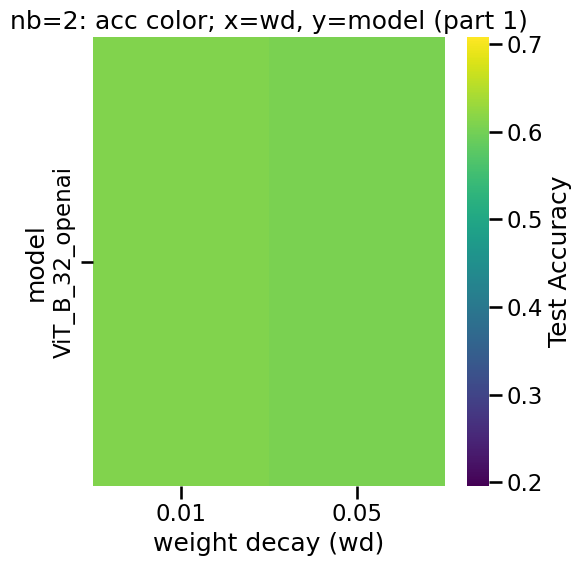

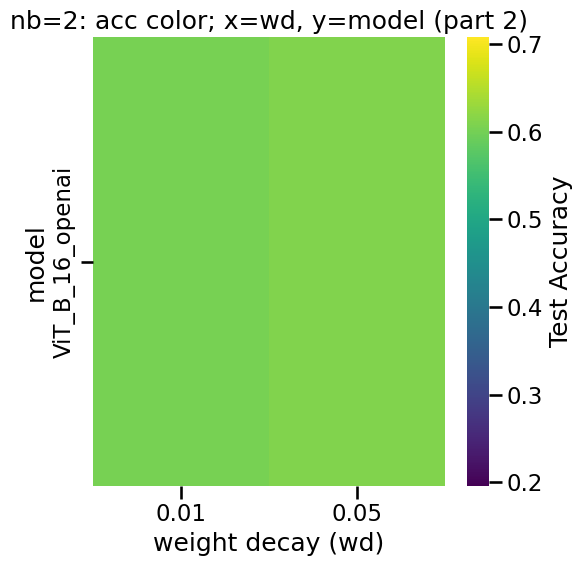

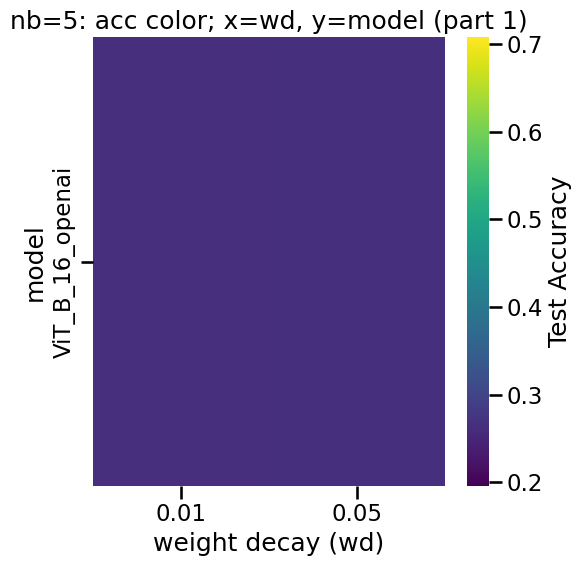

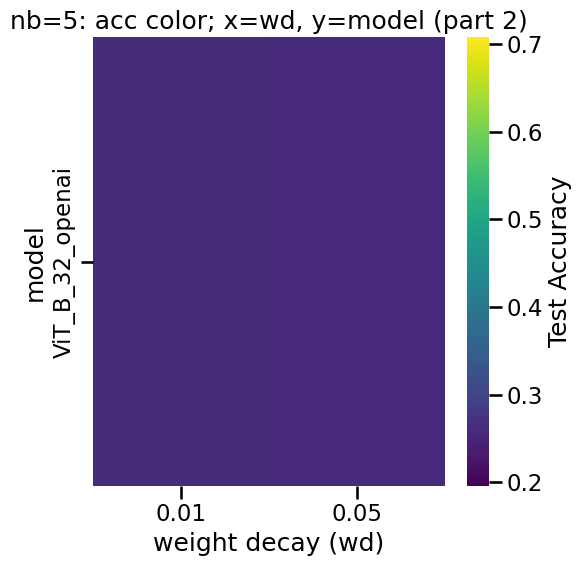

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_context("talk")

if df.empty:
    print("No runs found to visualize.")
else:
    # Ensure model_id_short exists even if df was rebuilt elsewhere
    if "model_id_short" not in df.columns:
        if "model_id" in df.columns:
            df["model_id_short"] = df["model_id"].str.replace("CLIP_MLP_", "", regex=False).str.replace("CLIP_LINEAR_", "", regex=False)
        else:
            df["model_id_short"] = df.get("run_name", pd.Series(dtype=str))

    # Consistent color limits across all heatmaps
    global_vmin = float(np.nanmin(df["accuracy"])) if not df["accuracy"].isna().all() else 0.0
    global_vmax = float(np.nanmax(df["accuracy"])) if not df["accuracy"].isna().all() else 1.0

    def plot_nb_heatmaps(df_nb: pd.DataFrame, nb_val: int) -> None:
        if df_nb.empty:
            print(f"No runs for nb={nb_val}")
            return
        # Aggregate over seeds and other hparams to get a single accuracy per (model, wd)
        agg = (df_nb.groupby(["model_id_short", "wd"], as_index=False)["accuracy"].mean())
        pivot = agg.pivot(index="model_id_short", columns="wd", values="accuracy")
        # Order models by their mean accuracy across wd
        pivot["_mean"] = pivot.mean(axis=1, skipna=True)
        pivot.sort_values("_mean", ascending=False, inplace=True)
        pivot.drop(columns=["_mean"], inplace=True)
        # Sort wd columns
        pivot = pivot.reindex(sorted(pivot.columns), axis=1)

        # Split models into at most two halves to fit everything
        n_models = pivot.shape[0]
        if n_models == 0:
            print(f"No models to show for nb={nb_val}")
            return
        split_idx = int(np.ceil(n_models / 2))
        halves = [pivot.iloc[:split_idx, :], pivot.iloc[split_idx:, :]] if n_models > 0 else [pivot]

        for i, part in enumerate(halves, start=1):
            if part.empty:
                continue
            n_y, n_x = part.shape
            plt.figure(figsize=(max(6, 1.2*n_x), max(6, 0.28*n_y)))
            ax = sns.heatmap(part, cmap="viridis", vmin=global_vmin, vmax=global_vmax,
                             annot=False, cbar_kws={"label": "Test Accuracy"})
            ax.set_xlabel("weight decay (wd)")
            ax.set_ylabel("model")
            suffix = f" (part {i})" if len(halves) > 1 else ""
            ax.set_title(f"nb={nb_val}: acc color; x=wd, y=model{suffix}")
            plt.tight_layout()
            plt.show()

    # Create up to two heatmaps per bin (2 and 5) covering all models
    for nb_val in [2, 5]:
        plot_nb_heatmaps(df[df["nb"] == nb_val].copy(), nb_val)
